In [ ]:
import sys
from pathlib import Path

# Notebook cell
%load_ext autoreload
%autoreload 2

# Get root directory (assuming notebook is in root/notebooks/)
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR

# Add src directory to Python path
sys.path.append(str(ROOT_DIR / 'src'))

# Verify path
print(f"Python will look in these locations:\n{sys.path}")


# --- Execute the processor ---
import utils
from config import date_str, DOWNLOAD_DIR, DEST_DIR



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python will look in these locations:
['C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\python311.zip', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\DLLs', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\Lib', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv', '', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\src', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\setuptools\\_vendor', 'c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\src', 'c:\\Users\\ping\\Files_w

In [91]:
import pandas as pd
# Set pandas display options to show more columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', 10)       # Limit to 10 rows for readability
pd.set_option('display.width', 1000)        # Let the display adjust to the window
# pd.set_option('display.max_colwidth', None) # Show full content of each cell
pd.set_option('display.max_rows', 200)
# pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

In [92]:
zscore_df = pd.read_parquet(f'..\data\{date_str}_zscore_df.parquet', engine='pyarrow')
cluster_stats_df = pd.read_parquet(f'..\data\{date_str}_cluster_stats_df.parquet', engine='pyarrow')
detailed_clusters_df = pd.read_parquet(f'..\data\{date_str}_detailed_clusters_df.parquet', engine='pyarrow')
df_data = pd.read_parquet(f'..\data\{date_str}_df_finviz_merged.parquet', engine='pyarrow')

In [ ]:
import pandas as pd


def select_stocks_from_clusters(cluster_stats_df, detailed_clusters_df, 
                               num_clusters=3, stocks_per_cluster=5,
                               min_cluster_size=5):
    """
    REMOVED (2025-04-06)
        # # Filter by volatility threshold
        # cluster_stocks = cluster_stocks[cluster_stocks['Volatility'] <= volatility_threshold]

    Pipeline to select stocks from better performing clusters
    
    Parameters:
    - cluster_stats_df: DataFrame with cluster statistics
    - detailed_clusters_df: DataFrame with detailed cluster information
    - num_clusters: Number of top clusters to select
    - stocks_per_cluster: Number of stocks to select from each cluster
    - min_cluster_size: Minimum size for a cluster to be considered
    
    Returns:
    - selected_stocks: DataFrame of selected stocks with their metrics
    - cluster_performance: DataFrame of selected clusters with their metrics
    """
    
    # ===== 1. Filter and Rank Clusters =====
    # Filter clusters by minimum size
    qualified_clusters = cluster_stats_df[cluster_stats_df['Size'] >= min_cluster_size].copy()
    
    # Calculate composite cluster score (weighted average of raw score and correlation)
    qualified_clusters['Composite_Cluster_Score'] = (
        0.7 * qualified_clusters['Avg_Raw_Score'] +  # Using Raw Score for selection
        0.3 * (1 - qualified_clusters['Avg_IntraCluster_Corr'])  # Prefer less correlated clusters
    )

    # Sort clusters by composite score
    ranked_clusters = qualified_clusters.sort_values('Composite_Cluster_Score', ascending=False)
    
    # Select top N clusters
    selected_clusters = ranked_clusters.head(num_clusters)
    cluster_ids = selected_clusters['Cluster_ID'].tolist()
    
    # ===== 2. Select Stocks from Each Cluster =====
    selected_stocks_list = []
    
    for cluster_id in cluster_ids:
        # Get stocks from this cluster
        cluster_stocks = detailed_clusters_df[detailed_clusters_df['Cluster_ID'] == cluster_id]
        
        # # Filter by volatility threshold
        # cluster_stocks = cluster_stocks[cluster_stocks['Volatility'] <= volatility_threshold]
        
        if len(cluster_stocks) > 0:
            # Sort by risk-adjusted score and select top stocks
            top_stocks = cluster_stocks.sort_values('Risk_Adj_Score', ascending=False).head(stocks_per_cluster)
            
            # Add cluster metrics to each stock
            cluster_metrics = selected_clusters[selected_clusters['Cluster_ID'] == cluster_id].iloc[0]
            for col in ['Composite_Cluster_Score', 'Avg_IntraCluster_Corr', 'Avg_Volatility', 
                       'Avg_Raw_Score', 'Avg_Risk_Adj_Score']:
                top_stocks[f'Cluster_{col}'] = cluster_metrics[col]
            
            selected_stocks_list.append(top_stocks)
    
    # Combine all selected stocks
    if selected_stocks_list:
        selected_stocks = pd.concat(selected_stocks_list)
        
        # Calculate position sizing weights (based on risk-adjusted scores)
        selected_stocks['Weight'] = (selected_stocks['Risk_Adj_Score'] / 
                                   selected_stocks['Risk_Adj_Score'].sum())
        
        # Sort by cluster then by score
        selected_stocks = selected_stocks.sort_values(['Cluster_ID', 'Risk_Adj_Score'], 
                                                   ascending=[True, False])
    else:
        selected_stocks = pd.DataFrame()
        print("Warning: No stocks met selection criteria")
    
    # ===== 3. Prepare Enhanced Output Reports =====
    # Cluster performance report - now showing both score types
    cluster_performance = selected_clusters.copy()
    cluster_performance['Stocks_Selected'] = cluster_performance['Cluster_ID'].apply(
        lambda x: len(selected_stocks[selected_stocks['Cluster_ID'] == x]) if not selected_stocks.empty else 0)
    
    # Add diversification metrics
    if not selected_stocks.empty:
        cluster_performance['Intra_Cluster_Diversification'] = 1 - cluster_performance['Avg_IntraCluster_Corr']
    
    return selected_stocks, cluster_performance


In [94]:
# Run the selection pipeline
selected_stocks, cluster_performance = select_stocks_from_clusters(
    cluster_stats_df=cluster_stats_df,
    detailed_clusters_df=detailed_clusters_df,
    num_clusters=3,
    stocks_per_cluster=3,
    min_cluster_size=5,
)

# Enhanced Output Display
print("\n=== CLUSTER SELECTION CRITERIA ===")
print("* Using Avg_Raw_Score for cluster selection")
print("* Using Risk_Adj_Score for stock selection within clusters")
print(f"* Selected top {len(cluster_performance)} clusters from {len(cluster_stats_df)} total")

print("\n=== SELECTED CLUSTERS (RANKED BY RAW SCORE) ===")
display_cols = ['Cluster_ID', 'Size', 'Avg_Raw_Score', 'Avg_Risk_Adj_Score', 
                'Avg_IntraCluster_Corr', 'Avg_Volatility', 'Composite_Cluster_Score',
                'Stocks_Selected', 'Intra_Cluster_Diversification']
print(cluster_performance[display_cols].sort_values('Avg_Raw_Score', ascending=False).to_string(index=False))

# NEW: Print top 8 stocks by Raw_Score for each selected cluster
print("\n=== TOP STOCKS BY RAW SCORE PER CLUSTER ===")
print("""* Volatility is the standard deviation of daily returns over the past 250 trading days
* Volatility for ' GLD' = sqrt(df_cov.loc['GLD', 'GLD'])
* volatility_threshold = 0.3 
* A standard deviation of 0.3 means the stock's price typically moves +/- 30% per day relative to its average daily return.
* Annualized Volatility ≈ Daily Volatility * sqrt(252)  ≈ 0.3 * 15.87 ≈ 4.76 or 476%""") 

for cluster_id in cluster_performance['Cluster_ID']:
    cluster_stocks = detailed_clusters_df[detailed_clusters_df['Cluster_ID'] == cluster_id]
    top_raw = cluster_stocks.nlargest(8, 'Raw_Score')[['Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Volatility']]
    
    print(f"Cluster {cluster_id} - Top 8 by Raw Score:")
    print(top_raw.to_string(index=False))
    print(f"Cluster Avg Raw Score: {cluster_performance[cluster_performance['Cluster_ID'] == cluster_id]['Avg_Raw_Score'].values[0]:.2f}")
    print(f"Cluster Avg Risk Adj Score: {cluster_performance[cluster_performance['Cluster_ID'] == cluster_id]['Avg_Risk_Adj_Score'].values[0]:.2f}")

print("\n=== FINAL SELECTED STOCKS (BY RISK-ADJ SCORE) ===")
print("* Stocks actually selected based on Risk_Adj_Score within each cluster")
print("* Position weights assigned based on Risk_Adj_Score")

available_cols = [col for col in ['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score', 
                                'Volatility', 'Weight', 'Cluster_Avg_Raw_Score',
                                'Cluster_Avg_Risk_Adj_Score'] 
                  if col in selected_stocks.columns]

print(selected_stocks[available_cols].sort_values(['Cluster_ID', 'Risk_Adj_Score'], 
                                                ascending=[True, False]).to_string(index=False))

# Calculate and print portfolio summary
if not selected_stocks.empty:
    print("\n=== PORTFOLIO SUMMARY ===")
    print(f"Total Stocks Selected: {len(selected_stocks)}")
    print(f"Average Raw Score: {selected_stocks['Raw_Score'].mean():.2f}")
    print(f"Average Risk-Adjusted Score: {selected_stocks['Risk_Adj_Score'].mean():.2f}")
    print(f"Average Volatility: {selected_stocks['Volatility'].mean():.2f}")
    print("\nCluster Distribution:")
    print(selected_stocks['Cluster_ID'].value_counts().to_string())


=== CLUSTER SELECTION CRITERIA ===
* Using Avg_Raw_Score for cluster selection
* Using Risk_Adj_Score for stock selection within clusters
* Selected top 3 clusters from 60 total

=== SELECTED CLUSTERS (RANKED BY RAW SCORE) ===
 Cluster_ID  Size  Avg_Raw_Score  Avg_Risk_Adj_Score  Avg_IntraCluster_Corr  Avg_Volatility  Composite_Cluster_Score  Stocks_Selected  Intra_Cluster_Diversification
         54    21         1.9813             84.3875                 0.8456          0.0296                   1.4332                3                         0.1544
         44     6         0.8945             35.3119                 0.7648          0.0269                   0.6967                3                         0.2352
         13     7         0.5580            283.2058                -0.0675          0.0221                   0.7108                3                         1.0675

=== TOP STOCKS BY RAW SCORE PER CLUSTER ===
* Volatility is the standard deviation of daily returns over the pa

In [95]:
print(f"Columns in cluster_performance:\n{cluster_performance.columns}\n")  

print(f"\n{cluster_performance[display_cols].sort_values('Avg_Raw_Score', ascending=False).to_string(index=False)}")

Columns in cluster_performance:
Index(['Cluster_ID', 'Size', 'Avg_IntraCluster_Corr', 'Avg_Raw_Score', 'Avg_Risk_Adj_Score', 'Avg_Volatility', 'Composite_Cluster_Score', 'Stocks_Selected', 'Intra_Cluster_Diversification'], dtype='object')


 Cluster_ID  Size  Avg_Raw_Score  Avg_Risk_Adj_Score  Avg_IntraCluster_Corr  Avg_Volatility  Composite_Cluster_Score  Stocks_Selected  Intra_Cluster_Diversification
         54    21         1.9813             84.3875                 0.8456          0.0296                   1.4332                3                         0.1544
         44     6         0.8945             35.3119                 0.7648          0.0269                   0.6967                3                         0.2352
         13     7         0.5580            283.2058                -0.0675          0.0221                   0.7108                3                         1.0675


In [96]:
selected_cluster_ids =selected_stocks['Cluster_ID'].unique()

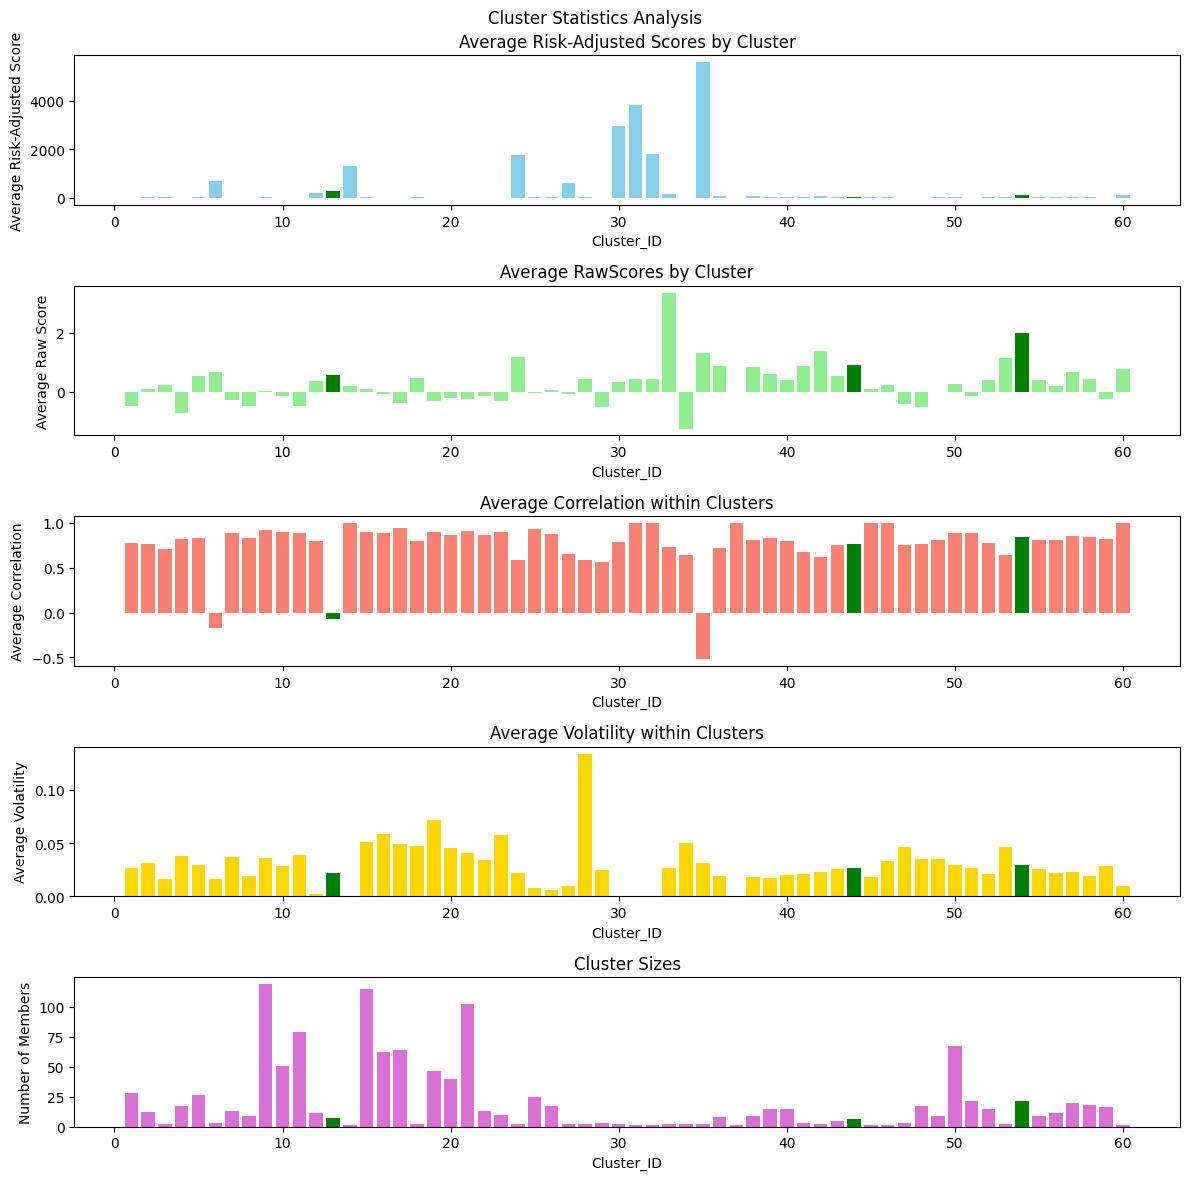

In [97]:
import matplotlib.pyplot as plt

PLOT_COLORS = ['lightgreen', 'skyblue', 'salmon', 'gold', 'orchid',
               'lightcoral', 'deepskyblue', 'mediumpurple', 'darkseagreen', 'tan']
HIGHLIGHT_COLOR = 'red'  # Color for highlighting selected clusters
HIGHLIGHT_COLOR = 'green'  # Color for highlighting selected clusters

# Create a figure with subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 12))
fig.suptitle('Cluster Statistics Analysis')

# Function to create bars with highlighted clusters
def create_bars(ax, x, y, color, highlight_ids):
    bars = ax.bar(x, y, color=[HIGHLIGHT_COLOR if cl_id in highlight_ids else color for cl_id in x])
    return bars

# Plot 1 Average Risk-Adjusted Score
create_bars(ax1, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_Risk_Adj_Score'], 
            'skyblue', selected_cluster_ids)
ax1.set_title('Average Risk-Adjusted Scores by Cluster')
ax1.set_xlabel('Cluster_ID')
ax1.set_ylabel('Average Risk-Adjusted Score')

# Plot 2 Average Raw Score
create_bars(ax2, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_Raw_Score'], 
            'lightgreen', selected_cluster_ids)
ax2.set_title('Average RawScores by Cluster')
ax2.set_xlabel('Cluster_ID')
ax2.set_ylabel('Average Raw Score')

# Plot 3: Average Correlation
create_bars(ax3, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_IntraCluster_Corr'], 
            'salmon', selected_cluster_ids)
ax3.set_title('Average Correlation within Clusters')
ax3.set_xlabel('Cluster_ID')
ax3.set_ylabel('Average Correlation')

# Plot 4: Average Volatility
create_bars(ax4, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_Volatility'], 
            'gold', selected_cluster_ids)
ax4.set_title('Average Volatility within Clusters')
ax4.set_xlabel('Cluster_ID')
ax4.set_ylabel('Average Volatility')

# Plot 5 Cluster Size
create_bars(ax5, cluster_stats_df['Cluster_ID'], cluster_stats_df['Size'], 
            'orchid', selected_cluster_ids)
ax5.set_title('Cluster Sizes')
ax5.set_xlabel('Cluster_ID')
ax5.set_ylabel('Number of Members')

plt.tight_layout()
plt.show()

In [98]:
selected_stocks

,Cluster_ID,Ticker,Raw_Score,Risk_Adj_Score,Volatility,Price,"MktCap AUM, M",Cluster_Composite_Cluster_Score,Cluster_Avg_IntraCluster_Corr,Cluster_Avg_Volatility,Cluster_Avg_Raw_Score,Cluster_Avg_Risk_Adj_Score,Weight
90,13,VGSH,0.8436,631.3677,0.0013,58.5800,22510.0000,0.7108,-0.0675,0.0221,0.5580,283.2058,0.2640
85,13,SPTS,0.8747,583.3842,0.0015,29.2000,6210.0000,0.7108,-0.0675,0.0221,0.5580,283.2058,0.2439
121,13,SCHO,0.7534,477.4985,0.0016,24.3000,10760.0000,0.7108,-0.0675,0.0221,0.5580,283.2058,0.1997
14,44,PSN,2.0564,73.6413,0.0279,63.2700,6760.0000,0.6967,0.7648,0.0269,0.8945,35.3119,0.0308
43,44,SAIC,1.1860,52.2590,0.0227,112.9600,5390.0000,0.6967,0.7648,0.0269,0.8945,35.3119,0.0219
68,44,LDOS,0.9908,41.6243,0.0238,139.6700,17910.0000,0.6967,0.7648,0.0269,0.8945,35.3119,0.0174
80,54,FYBR,0.9170,245.7471,0.0037,35.9600,8980.0000,1.4332,0.8456,0.0296,1.9813,84.3875,0.1028
10,54,SGOL,2.1348,143.0964,0.0149,30.2600,4700.0000,1.4332,0.8456,0.0296,1.9813,84.3875,0.0598
11,54,GLDM,2.1342,142.9425,0.0149,62.8000,12990.0000,1.4332,0.8456,0.0296,1.9813,84.3875,0.0598


In [99]:
cluster_performance

,Cluster_ID,Size,Avg_IntraCluster_Corr,Avg_Raw_Score,Avg_Risk_Adj_Score,Avg_Volatility,Composite_Cluster_Score,Stocks_Selected,Intra_Cluster_Diversification
53,54,21,0.8456,1.9813,84.3875,0.0296,1.4332,3,0.1544
12,13,7,-0.0675,0.5580,283.2058,0.0221,0.7108,3,1.0675
43,44,6,0.7648,0.8945,35.3119,0.0269,0.6967,3,0.2352


In [100]:
# Step 1: Drop Tickers 
drop_tickers = ['BECN']
selected_stocks = selected_stocks[~selected_stocks['Ticker'].isin(drop_tickers)].copy()

# Step 1: Drop Cluster 
drop_cluster = 0
selected_stocks = selected_stocks[selected_stocks['Cluster_ID'] != drop_cluster].copy()

# Step 2: Recalculate weights based on remaining stocks' Risk_Adj_Scores
selected_stocks['Weight'] = selected_stocks['Risk_Adj_Score'] / selected_stocks['Risk_Adj_Score'].sum()

# Step 3: Display the updated portfolio
print(f"\n=== UPDATED PORTFOLIO (CLUSTER {drop_cluster}, TICKER {drop_tickers} REMOVED) ===")
# sorted_selected_stocks_df = selected_stocks[['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Weight', 'Volatility']] \
#               .sort_values(['Weight', 'Cluster_ID'], ascending=[False, False])
# Select columns, sort, and then set 'Ticker' as the index
sorted_selected_stocks_df = selected_stocks[['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Weight', 'Volatility']] \
              .sort_values(['Weight', 'Cluster_ID'], ascending=[False, False]) \
              .set_index('Ticker')



print(sorted_selected_stocks_df.to_string(index=True))

# Step 4: Extract the 'Ticker' column from the sorted DataFrame
ticker_order = sorted_selected_stocks_df.index.tolist()


# Optional: Print weight redistribution summary
original_total = 1.0
new_total = selected_stocks['Weight'].sum()
print(f"\nWeights redistributed from Cluster {drop_cluster} & Ticker {drop_tickers}: {original_total - new_total:.1%}")
print(f"New total weights sum to: {new_total:.0%}")


=== UPDATED PORTFOLIO (CLUSTER 0, TICKER ['BECN'] REMOVED) ===
        Cluster_ID  Raw_Score  Risk_Adj_Score  Weight  Volatility
Ticker                                                           
VGSH            13     0.8436        631.3677  0.2640      0.0013
SPTS            13     0.8747        583.3842  0.2439      0.0015
SCHO            13     0.7534        477.4985  0.1997      0.0016
FYBR            54     0.9170        245.7471  0.1028      0.0037
SGOL            54     2.1348        143.0964  0.0598      0.0149
GLDM            54     2.1342        142.9425  0.0598      0.0149
PSN             44     2.0564         73.6413  0.0308      0.0279
SAIC            44     1.1860         52.2590  0.0219      0.0227
LDOS            44     0.9908         41.6243  0.0174      0.0238

Weights redistributed from Cluster 0 & Ticker ['BECN']: 0.0%
New total weights sum to: 100%


In [101]:
sorted_selected_stocks_df

,Cluster_ID,Raw_Score,Risk_Adj_Score,Weight,Volatility
Ticker,,,,,
VGSH,13,0.8436,631.3677,0.2640,0.0013
SPTS,13,0.8747,583.3842,0.2439,0.0015
SCHO,13,0.7534,477.4985,0.1997,0.0016
FYBR,54,0.9170,245.7471,0.1028,0.0037
SGOL,54,2.1348,143.0964,0.0598,0.0149
GLDM,54,2.1342,142.9425,0.0598,0.0149
PSN,44,2.0564,73.6413,0.0308,0.0279
SAIC,44,1.1860,52.2590,0.0219,0.0227
LDOS,44,0.9908,41.6243,0.0174,0.0238


In [102]:
final_selected_stocks = pd.concat([sorted_selected_stocks_df, df_data.loc[ticker_order]], axis=1)
final_selected_stocks

,Cluster_ID,Raw_Score,Risk_Adj_Score,Weight,Volatility,Company,Info,"MktCap AUM, M",Beta,RSI,Perf YTD %,Perf 3D %,Perf Week %,Perf Month %,Perf Quart %,Perf Half %,Perf Year %,SMA20 %,SMA50 %,SMA200 %,50D High %,50D Low %,52W High %,52W Low %,All-Time High %,All-Time Low %,ATR,ATR/Price %,Volatility W %,Volatility M %,"Volume, M","Avg Volume, M",Rel Volume,Price,Change %,Dividend %,Sharpe 3d,Sortino 3d,Omega 3d,Sharpe 5d,Sortino 5d,Omega 5d,Sharpe 10d,Sortino 10d,Omega 10d,Sharpe 15d,Sortino 15d,Omega 15d,Sharpe 30d,Sortino 30d,Omega 30d,Sharpe 60d,Sortino 60d,Omega 60d,Sharpe 120d,Sortino 120d,Omega 120d,Sharpe 250d,Sortino 250d,Omega 250d
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VGSH,13,0.8436,631.3677,0.2640,0.0013,Vanguard Short-Term Treasury ETF,"Financial, Exchange Traded Fund, Bonds - Treas...",22510.0000,0.0400,51.2100,0.6900,-0.1704,-0.2200,0.1700,0.6900,0.0700,1.3100,-0.0100,0.2200,0.2600,-0.6100,0.8400,-0.9300,1.9500,-20.9500,2.2200,0.1400,0.2390,0.3900,0.1700,5.6913,3.5200,1.6200,58.5800,0.0300,4.1700,-7.5896,-9.0561,0.1932,-8.8577,-8.7378,0.1439,0.8247,1.4321,1.1830,0.8879,1.4583,1.1838,0.7163,1.1299,1.1375,1.9710,3.2038,1.4145,0.3404,0.5109,1.0586,1.1280,1.7535,1.2103
SPTS,13,0.8747,583.3842,0.2439,0.0015,SPDR Portfolio Short Term Treasury ETF,"Financial, Exchange Traded Fund, Bonds - Treas...",6210.0000,0.0500,52.6400,0.6500,-0.0684,-0.1400,0.2100,0.7600,0.1000,1.3900,0.0500,0.2800,0.3200,-0.5600,0.9000,-0.8800,2.0300,-12.3900,2.1700,0.0700,0.2397,0.3600,0.1700,3.8533,1.6200,2.3800,29.2000,0.1000,4.1800,-6.4677,-8.2068,0.2689,-6.0221,-6.8150,0.3822,1.2097,1.7830,1.2238,1.0813,1.5705,1.2014,0.8030,1.1419,1.1402,1.9309,2.8699,1.3779,0.3523,0.5033,1.0584,1.1075,1.6716,1.1983
SCHO,13,0.7534,477.4985,0.1997,0.0016,Schwab Short-Term U.S. Treasury ETF,"Financial, Exchange Traded Fund, Bonds - Treas...",10760.0000,0.0500,51.2300,1.0000,-0.1233,-0.2500,0.1600,0.6200,0.0200,1.2700,0.0000,0.2200,0.2300,-0.6100,0.8300,-0.9600,1.8900,-6.5200,1.9900,0.0600,0.2469,0.3900,0.1800,6.8583,4.0300,1.7000,24.3000,0.0800,4.2300,-7.1884,-8.7643,0.2192,-7.5249,-7.8875,0.2748,0.5475,0.9052,1.1042,0.1705,0.2597,1.0301,0.4593,0.6801,1.0820,1.5753,2.4196,1.3036,0.2481,0.3631,1.0433,0.1704,0.2419,1.0299
FYBR,54,0.9170,245.7471,0.1028,0.0037,Frontier Communications Parent Inc,"Communication Services, Telecom Services",8980.0000,1.0100,55.8200,3.6300,1.2109,0.0600,0.3100,1.8400,1.7300,49.1500,0.4200,0.3800,7.3200,-0.6600,1.8300,-8.2900,68.7500,-8.2900,208.6700,0.2600,0.7230,1.2400,0.6400,3.1715,3.0600,1.0400,35.9600,0.4200,NaN,30.8720,63320.7723,5642.0627,6.5333,16.2437,3.0465,0.0209,0.0306,1.0035,0.5997,0.8745,1.1103,-0.9752,-1.3347,0.8435,0.2887,0.4189,1.0546,-0.4641,-0.6105,0.9159,1.0231,2.6862,1.4374
SGOL,54,2.1348,143.0964,0.0598,0.0149,abrdn Physical Gold Shares ETF,"Financial, Exchange Traded Fund, Commodities &...",4700.0000,0.1400,66.9100,20.8000,6.5868,2.0900,8.1500,19.0400,20.8500,34.6100,3.8900,7.1700,18.5400,1.0700,15.5000,1.0700,39.0600,1.0700,206.6800,0.4700,1.5532,2.0600,1.0800,6.9192,5.3800,1.2900,30.2600,2.5400,NaN,65.8133,63320.7723,5642.0627,7.1576,17.7708,3.2389,2.6650,4.9806,1.5707,3.5131,6.5471,1.8596,4.6429,8.7998,2.2659,4.0261,7.1698,1.9889,1.9087,2.7929,1.3702,1.7344,2.5317,1.3295
GLDM,54,2.1342,142.9425,0.0598,0.0149,SPDR Gold MiniShares Trust,"Financial, Exchange Traded Fund, Commodities &...",12990.0000,0.1400,66.9500,20.7900,6.5129,2.0500,8.1500,18.9800,20.8200,34.7400,3.8500,7.1500,18.5300,1.1100,15.4900,1.1100,39.1500,1.1100,167.5500,0.9700,1.5446,2.0800,1.0800,6.8926,3.6000,1.9100,62.8000,2.5100,NaN,61.1444,63320.7723,5642.0627,6.9498,17.3677,3.1881,2.6163,4.9302,1.5744,3.4668,6.5149,1.8585,4.6812,8.9640,2.2981,4.0216,7.1920,1.9858,1.8871,2.7607,1.3659,1.7278,2.5207,1.3287
PSN,44,2.0564,73.6413,0.0308,0.0279,Parsons Corp,"Technology, Information Technology Services",6760.0000,0.5600,55.0400,-31.4100,7.4558,3.5900,10.2100,-31.1200,-40.8100,-21.3800,4.9200,-1.2500,-27.3800,-22.3200,15.97

In [103]:
final_cluster_ids = final_selected_stocks['Cluster_ID'].unique().tolist()

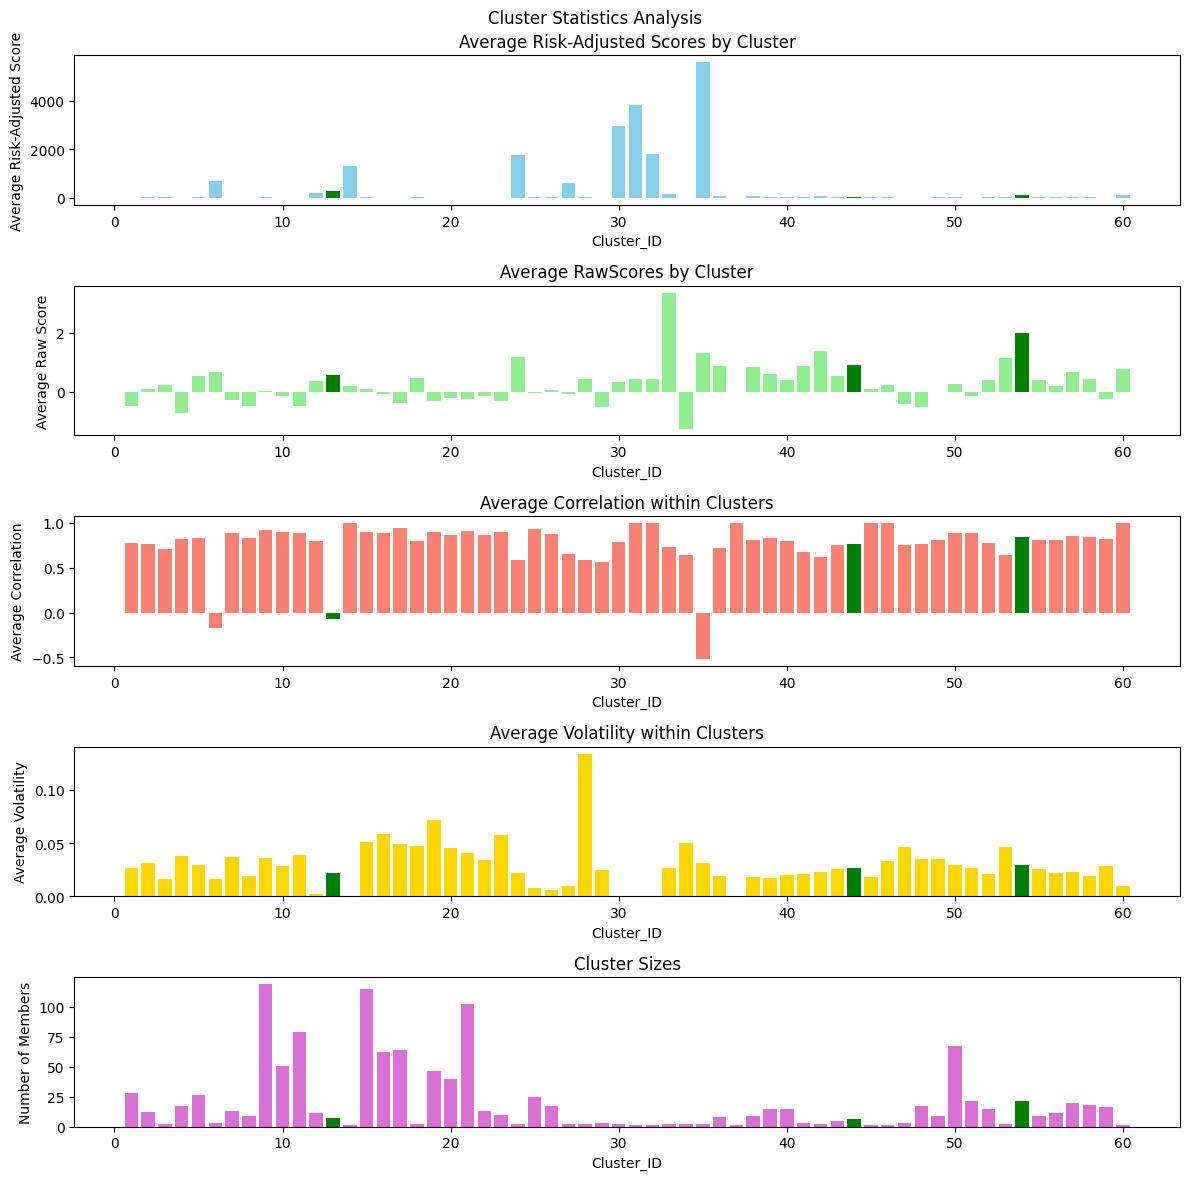

In [104]:
import matplotlib.pyplot as plt

PLOT_COLORS = ['lightgreen', 'skyblue', 'salmon', 'gold', 'orchid',
               'lightcoral', 'deepskyblue', 'mediumpurple', 'darkseagreen', 'tan']
HIGHLIGHT_COLOR = 'red'  # Color for highlighting selected clusters
HIGHLIGHT_COLOR = 'green'  # Color for highlighting selected clusters

# Create a figure with subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 12))
fig.suptitle('Cluster Statistics Analysis')

# Function to create bars with highlighted clusters
def create_bars(ax, x, y, color, highlight_ids):
    bars = ax.bar(x, y, color=[HIGHLIGHT_COLOR if cl_id in highlight_ids else color for cl_id in x])
    return bars

# Plot 1 Average Risk-Adjusted Score
create_bars(ax1, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_Risk_Adj_Score'], 
            'skyblue', final_cluster_ids)
ax1.set_title('Average Risk-Adjusted Scores by Cluster')
ax1.set_xlabel('Cluster_ID')
ax1.set_ylabel('Average Risk-Adjusted Score')

# Plot 2 Average Raw Score
create_bars(ax2, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_Raw_Score'], 
            'lightgreen', final_cluster_ids)
ax2.set_title('Average RawScores by Cluster')
ax2.set_xlabel('Cluster_ID')
ax2.set_ylabel('Average Raw Score')

# Plot 3: Average Correlation
create_bars(ax3, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_IntraCluster_Corr'], 
            'salmon', final_cluster_ids)
ax3.set_title('Average Correlation within Clusters')
ax3.set_xlabel('Cluster_ID')
ax3.set_ylabel('Average Correlation')

# Plot 4: Average Volatility
create_bars(ax4, cluster_stats_df['Cluster_ID'], cluster_stats_df['Avg_Volatility'], 
            'gold', final_cluster_ids)
ax4.set_title('Average Volatility within Clusters')
ax4.set_xlabel('Cluster_ID')
ax4.set_ylabel('Average Volatility')

# Plot 5 Cluster Size
create_bars(ax5, cluster_stats_df['Cluster_ID'], cluster_stats_df['Size'], 
            'orchid', final_cluster_ids)
ax5.set_title('Cluster Sizes')
ax5.set_xlabel('Cluster_ID')
ax5.set_ylabel('Number of Members')

plt.tight_layout()
plt.show()

In [105]:
output_filename_tsv = f"..\picks\{date_str}_selected_stocks.tsv"

final_selected_stocks.to_csv(output_filename_tsv, sep='\t', encoding='utf-8', index=True)

In [106]:
final_selected_stocks.to_parquet(f'..\picks\{date_str}_selected_stocks.parquet', engine='pyarrow', compression='zstd')
cluster_stats_df.to_parquet(f'..\picks\{date_str}_cluster_stats_df.parquet', engine='pyarrow', compression='zstd')

In [107]:
# Calculate summary statistics for cluster_stats_df
stats_summary = pd.DataFrame({
    'Count': cluster_stats_df.count(numeric_only=True),
    'Sum': cluster_stats_df.sum(numeric_only=True),
    'Mean': cluster_stats_df.mean(numeric_only=True),
    'Std': cluster_stats_df.std(numeric_only=True),
    'Mean+1Std (68%)': cluster_stats_df.mean(numeric_only=True) + cluster_stats_df.std(numeric_only=True),
    'Mean-1Std (68%)': cluster_stats_df.mean(numeric_only=True) - cluster_stats_df.std(numeric_only=True),
    'Mean+2Std (95%)': cluster_stats_df.mean(numeric_only=True) + 2*cluster_stats_df.std(numeric_only=True),
    'Mean-2Std (95%)': cluster_stats_df.mean(numeric_only=True) - 2*cluster_stats_df.std(numeric_only=True),
    'Min': cluster_stats_df.min(numeric_only=True),
    'Max': cluster_stats_df.max(numeric_only=True),
})

print("Summary Statistics for Cluster Data:")
display(stats_summary.round(4))

Summary Statistics for Cluster Data:


,Count,Sum,Mean,Std,Mean+1Std (68%),Mean-1Std (68%),Mean+2Std (95%),Mean-2Std (95%),Min,Max
Cluster_ID,60,1830.0000,30.5000,17.4642,47.9642,13.0358,65.4285,-4.4285,1.0000,60.0000
Size,60,1189.0000,19.8167,27.9567,47.7733,-8.1400,75.7300,-36.0967,1.0000,119.0000
Avg_IntraCluster_Corr,60,46.2122,0.7702,0.2641,1.0344,0.5061,1.2985,0.2419,-0.5173,1.0000
Avg_Raw_Score,60,15.9528,0.2659,0.7065,0.9724,-0.4406,1.6789,-1.1471,-1.2616,3.3738
Avg_Risk_Adj_Score,60,19693.4309,328.2238,985.4021,1313.6260,-657.1783,2299.0281,-1642.5804,-27.4355,5586.4137
Avg_Volatility,60,1.7251,0.0288,0.0208,0.0496,0.0079,0.0704,-0.0129,0.0001,0.1340


In [108]:
# Sort by Avg_Raw_Score in descending order
sorted_by_Avg_Raw_Score = cluster_stats_df.sort_values('Avg_Raw_Score', ascending=False)
print(f'sorted_by_Avg_Raw_Score')
display(sorted_by_Avg_Raw_Score.head(10))

sorted_by_Avg_Raw_Score


,Cluster_ID,Size,Avg_IntraCluster_Corr,Avg_Raw_Score,Avg_Risk_Adj_Score,Avg_Volatility
32,33,2,0.7276,3.3738,134.1458,0.0266
53,54,21,0.8456,1.9813,84.3875,0.0296
41,42,2,0.6159,1.3897,62.0238,0.0232
34,35,2,-0.5173,1.3245,5586.4137,0.0314
23,24,2,0.5873,1.1915,1772.7512,0.0222
52,53,2,0.6470,1.1545,26.9540,0.0464
43,44,6,0.7648,0.8945,35.3119,0.0269
40,41,3,0.6763,0.8712,41.1321,0.0210
35,36,8,0.7193,0.8647,46.2177,0.0190
37,38,9,0.8067,0.8349,48.4492,0.0176


In [109]:
print(f"\nVariance for 'GLD' = df_cov.loc['GLD', 'GLD']")
print(f"volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5")


Variance for 'GLD' = df_cov.loc['GLD', 'GLD']
volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5


In [110]:
pd.set_option('display.max_rows', 200)

print(f"Variance for 'GLD' = df_cov.loc['GLD', 'GLD']")
print(f"volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5")
print(f"\nUse sorted_df_desc.head(200) to prevent truncation and see the top 200 rows")

sorted_df_desc = detailed_clusters_df.sort_values(by='Risk_Adj_Score', ascending=False)
print(sorted_df_desc.head(200))

Variance for 'GLD' = df_cov.loc['GLD', 'GLD']
volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5

Use sorted_df_desc.head(200) to prevent truncation and see the top 200 rows
     Cluster_ID Ticker  Raw_Score  Risk_Adj_Score  Volatility    Price  MktCap AUM, M
27           35   USFR     1.5867      11155.8783      0.0001  50.3700     18800.0000
221          31   SGOV     0.4124       3824.2041      0.0001 100.4400     42140.0000
247          30    BIL     0.3555       3533.3979      0.0001  91.5200     46560.0000
167          24   TBIL     0.5633       3504.4534      0.0002  49.8900      5370.0000
267          30    SHV     0.2986       2408.3857      0.0001 110.2200     20750.0000
231           6   GBIL     0.3932       1924.7733      0.0002  99.9600      6340.0000
214          32   BOXX     0.4232       1797.8729      0.0002 111.6000      5770.0000
352          14   TFLO     0.1884       1315.2648      0.0001  50.5200      7050.0000
210          27   ICSH     0.4311       1266.3201 

In [111]:
pd.set_option('display.max_rows', 200)

print(detailed_clusters_df)

      Cluster_ID Ticker  Raw_Score  Risk_Adj_Score  Volatility    Price  MktCap AUM, M
484            1   VUSB     0.0481         48.7273      0.0010  49.5000      4950.0000
339            1   FLOT     0.2009         41.6779      0.0048  50.3100      8790.0000
323            1    ABT     0.2170         11.5432      0.0188 124.5000    215920.0000
470            1     EW     0.0590          2.7924      0.0211  68.2600     39980.0000
483            1    RDY     0.0486          2.0549      0.0237  12.7100     10590.0000
...          ...    ...        ...             ...         ...      ...            ...
1063          59     CF    -0.6565        -24.1136      0.0272  69.9700     11650.0000
1019          59    PBA    -0.5704        -24.4135      0.0234  35.1600     20410.0000
1155          59   BMRN    -1.0417        -27.9462      0.0373  56.3600     10750.0000
1126          59    EPD    -0.8836        -39.7523      0.0222  28.9500     62700.0000
110           60   BECN     0.7835         